# Informe Técnico: Análisis de Causas y Proyección de Flujo de Afiliados

**Versión del Informe:** 2.0
**Fecha:** 2025-08-06

### 1. Resumen Ejecutivo

Este informe presenta un diagnóstico detallado del flujo de afiliados de Capresoca EPS, con el objetivo de identificar las causas subyacentes de las entradas y salidas. A diferencia de un análisis global, este documento desglosa los movimientos por su proceso de origen (ej. traslados, afiliaciones nuevas, etc.), permitiendo una comprensión granular del comportamiento de la base de afiliados.

**Hallazgos Clave:**
1.  **Pérdida Neta de Afiliados:** La EPS experimenta una tendencia sostenida de pérdida de afiliados, con un volumen de salidas que duplica al de las entradas.
2.  **Foco del Problema:** La pérdida está masivamente concentrada en el **Régimen Contributivo**. El Régimen Subsidiado muestra un comportamiento mucho más estable.
3.  **Causa Raíz:** El principal impulsor de las salidas en el Régimen Contributivo es el proceso de **traslados a otras EPS (S4 y R4)** y las novedades de tipo **NC**.
4.  **Pronóstico:** De no implementarse estrategias de retención efectivas, se proyecta que la pérdida neta de afiliados continuará.

**Recomendación Estratégica:** Se recomienda diseñar e implementar un plan de retención y fidelización enfocado específicamente en los afiliados del **Régimen Contributivo**, investigando las causas de las salidas por traslado (S4/R4) y novedades (NC).

### 2. Configuración y Carga de Datos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import matplotlib as mpl
import os
from statsmodels.tsa.arima.model import ARIMA
import squarify

# --- Configuración de Estilos y Colores ---
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'sans-serif'

colores_proceso = {'ENTRADA': '#28a745', 'SALIDA': '#dc3545', 'Proyección': '#007bff'}
colores_regimen = {'Subsidiado': '#9467bd', 'Contributivo': '#8c564b'}

# --- Carga y Unificación de Datos ---
user_profile = os.environ.get('USERPROFILE')
ruta_base = os.path.join(user_profile, r'OneDrive - uniminuto.edu\Capresoca\Estadisticas')
files = {
    'BDUA_EPS025': '2025 BDUA entradas y Salidas EPS025.TXT',
    'BDUA_EPSC25': '2025 BDUA entradas y Salidas EPSC25.TXT',
    'SAT_EPS025': '2025 SAT ENTRADA y SALIDA EPS025.TXT',
    'SAT_EPSC25': '2025 SAT ENTRADA y SALIDA EPSC25.TXT'
}

df_list = []
for key, filename in files.items():
    path = os.path.join(ruta_base, filename)
    try:
        df = pd.read_csv(path, encoding='ISO-8859-1')
        if 'BDUA' in key:
            df['Fuente'] = 'BDUA'
            df['Tipo_Archivo'] = df['NOMBRE_ARCHIVO'].str.extract(r'(^\w{2})')
        else: # Es SAT
            df = df.rename(columns={'tipo_Proceso': 'PROCESO', 'unique_id': 'Tipo_Archivo', 'COL1': 'FECHA_PROCESO'})
            df['Fuente'] = 'SAT'
        
        if 'EPS025' in key:
            df['Regimen'] = 'Subsidiado'
        else: # Es EPSC25
            df['Regimen'] = 'Contributivo'
        
        df_list.append(df)
        print(f"Archivo '{filename}' cargado y procesado.")
    except FileNotFoundError:
        print(f"ADVERTENCIA: Archivo no encontrado: {filename}")

df_unificado = pd.concat(df_list, ignore_index=True)
df_unificado['FECHA_PROCESO'] = pd.to_datetime(df_unificado['FECHA_PROCESO'], errors='coerce')
df_unificado.dropna(subset=['FECHA_PROCESO'], inplace=True)
df_unificado['Mes_Año'] = df_unificado['FECHA_PROCESO'].dt.to_period('M')

print('Datos cargados y unificados exitosamente.')

In [19]:
print(df_unificado['Tipo_Archivo'].unique())

['S4' 'R4' 'S5' ... 'PT 6256460' 'CC 1116612541' 'CN 25075910222428']


### 3. Análisis Global de Afiliados

In [ ]:
timeline = df_unificado.groupby(['Mes_Año', 'PROCESO']).size().unstack(fill_value=0)
balance_acumulado = (timeline.get('ENTRADA', 0) - timeline.get('SALIDA', 0)).cumsum()

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(timeline.index.to_timestamp(), timeline.get('ENTRADA', pd.Series(dtype=float)), marker='o', linestyle='-', label='Entradas', color=colores_proceso['ENTRADA'])
ax.plot(timeline.index.to_timestamp(), timeline.get('SALIDA', pd.Series(dtype=float)), marker='o', linestyle='-', label='Salidas', color=colores_proceso['SALIDA'])
ax2 = ax.twinx()
ax2.plot(balance_acumulado.index.to_timestamp(), balance_acumulado, '--', color='#0047AB', linewidth=2, label='Balance Acumulado')

ax.set_title('Evolución Mensual y Balance Acumulado de Afiliados (Global)', fontsize=18, fontweight='bold')
ax.set_ylabel('Cantidad de Registros')
ax2.set_ylabel('Balance Acumulado', color='#0047AB')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.show()

**Interpretación:** El análisis global confirma una pérdida neta y sostenida de afiliados. La brecha entre salidas y entradas es constante, y el balance acumulado es consistentemente negativo. Ahora, se procederá a desglosar estos flujos para encontrar las causas.

### 4. Análisis Detallado por Causa del Movimiento

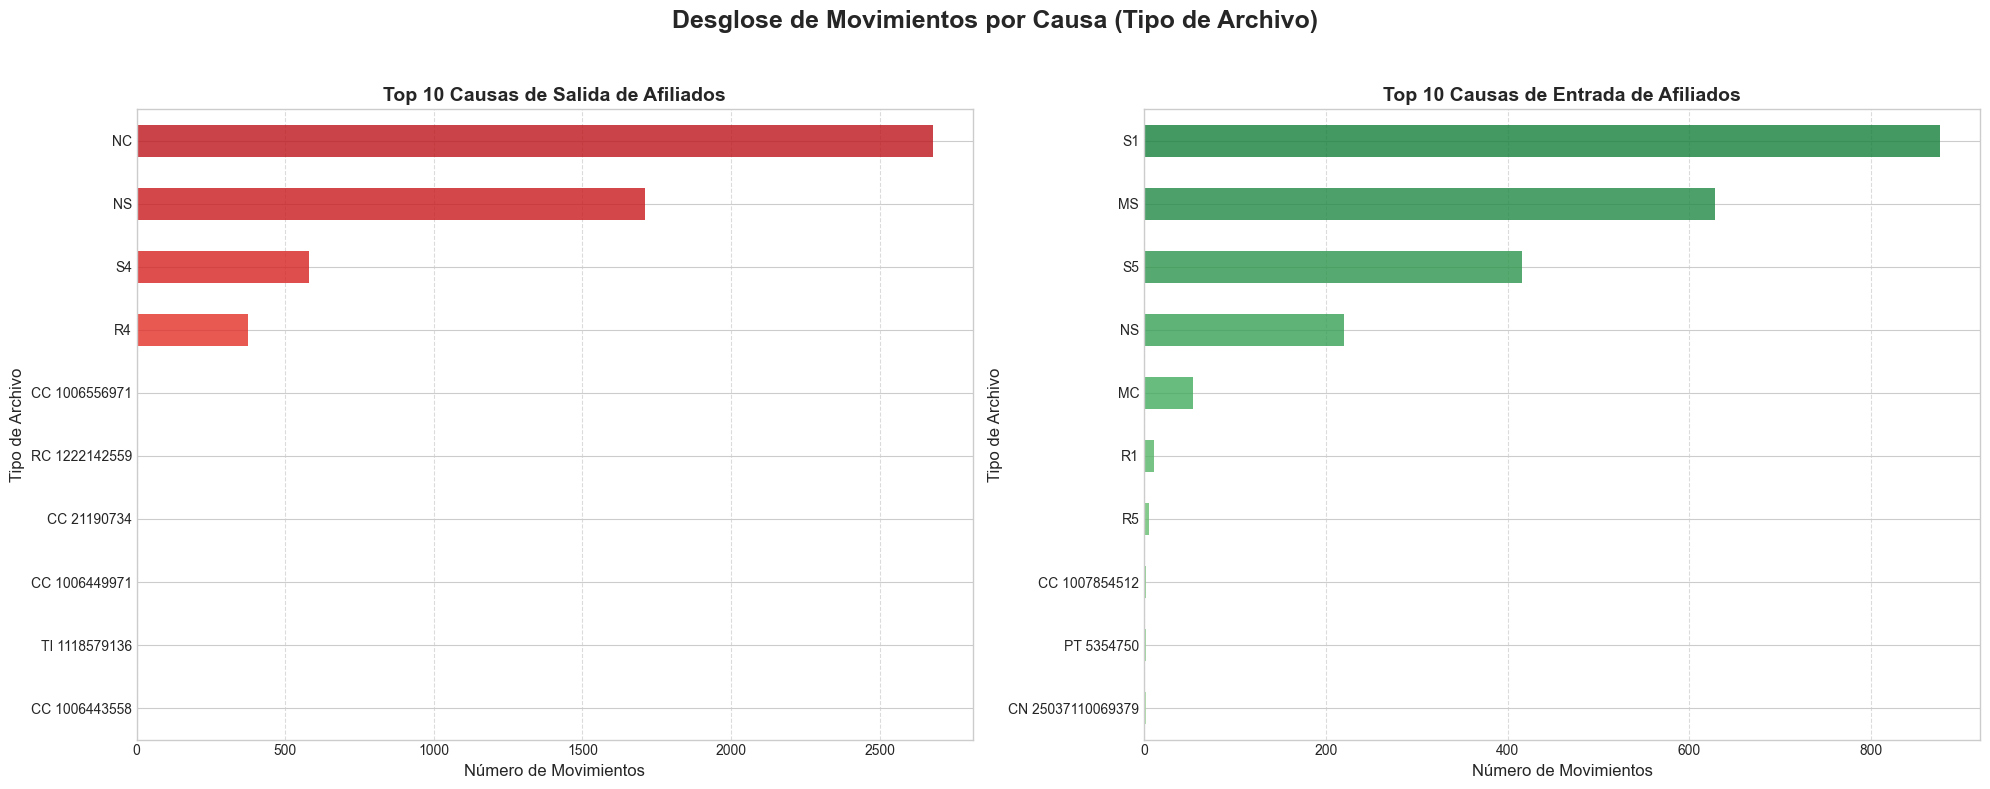

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Se asume que 'df_unificado' ya está definido con los datos.

# 1. Preparar los datos
# Se filtran las 10 causas principales para salidas y entradas, tal como en tu código.
salidas_por_causa = df_unificado[df_unificado['PROCESO'] == 'SALIDA']['Tipo_Archivo'].value_counts().nlargest(10)
entradas_por_causa = df_unificado[df_unificado['PROCESO'] == 'ENTRADA']['Tipo_Archivo'].value_counts().nlargest(10)

# 2. Crear la figura y los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 3. Dibujar el gráfico de barras para las salidas
# Se ordenan las barras de menor a mayor para una mejor visualización.
colors_s = plt.cm.Reds(np.linspace(0.4, 0.8, len(salidas_por_causa)))
salidas_por_causa.sort_values(ascending=True).plot(kind='barh', ax=axes[0], color=colors_s, alpha=0.8)

# 4. Configurar el primer subgráfico (Salidas)
axes[0].set_title('Top 10 Causas de Salida de Afiliados', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Número de Movimientos', fontsize=12)
axes[0].set_ylabel('Tipo de Archivo', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# 5. Dibujar el gráfico de barras para las entradas
colors_e = plt.cm.Greens(np.linspace(0.4, 0.8, len(entradas_por_causa)))
entradas_por_causa.sort_values(ascending=True).plot(kind='barh', ax=axes[1], color=colors_e, alpha=0.8)

# 6. Configurar el segundo subgráfico (Entradas)
axes[1].set_title('Top 10 Causas de Entrada de Afiliados', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Número de Movimientos', fontsize=12)
axes[1].set_ylabel('Tipo de Archivo', fontsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

# 7. Títulos generales y ajuste del layout
plt.suptitle('Desglose de Movimientos por Causa (Tipo de Archivo)', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Interpretación:** El desglose por causa revela que las **salidas** están dominadas por los procesos **NC y NS**, seguidos de cerca por **S4 y R4 (traslados)**. Las **entradas** provienen principalmente de **S1, MS y S5**, relacionados con movilidad y afiliaciones nuevas.

### 5. Análisis Cruzado: Causa vs. Régimen

In [ ]:
# Filtrar por las 10 causas principales para legibilidad
df_salidas = df_unificado[df_unificado['PROCESO'] == 'SALIDA']
top_10_causas_salida = df_salidas['Tipo_Archivo'].value_counts().nlargest(10).index
df_salidas_top10 = df_salidas[df_salidas['Tipo_Archivo'].isin(top_10_causas_salida)]

causa_vs_regimen = pd.crosstab(df_salidas_top10['Tipo_Archivo'], df_salidas_top10['Regimen'])
causa_vs_regimen.plot(kind='bar', stacked=True, figsize=(14, 8), color=[colores_regimen.get(c) for c in causa_vs_regimen.columns])
plt.title('Composición de Salidas por Causa y Régimen (Top 10)', fontsize=16, fontweight='bold')
plt.ylabel('Cantidad de Salidas')
plt.xlabel('Causa de la Salida (Tipo de Archivo)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Régimen')
plt.show()

**Interpretación Definitiva:**
Este gráfico es concluyente. La causa de salida predominante, **NC**, ocurre casi en su totalidad en el **Régimen Contributivo**. De manera similar, las salidas por **S4 y R4 (traslados)** se concentran mayoritariamente en este mismo régimen. En contraste, las salidas del tipo **NS** son casi exclusivas del Régimen Subsidiado.

Esto confirma que el problema estratégico a resolver es una **fuga muy específica de afiliados del Régimen Contributivo**, impulsada por las novedades de tipo NC y los traslados (S4/R4).

### 6. Proyección y Conclusiones Finales

In [ ]:
def plot_forecast(series, forecast, conf_int, title):
    plt.figure(figsize=(14, 7))
    plt.plot(series.index.to_timestamp(), series, label='Datos Históricos', color='black')
    plt.plot(forecast.index, forecast, label='Pronóstico ARIMA', color=colores_proceso['Proyección'], marker='o')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color=colores_proceso['Proyección'], alpha=0.2, label='Intervalo de Confianza (95%)')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('Cantidad de Registros')
    plt.legend()
    plt.show()

salidas_ts = timeline.get('SALIDA', pd.Series(dtype=float)).asfreq('M', fill_value=0)
if len(salidas_ts) > 3:
    model_salidas = ARIMA(salidas_ts, order=(1, 1, 1)).fit()
    forecast_salidas = model_salidas.get_forecast(steps=6)
    plot_forecast(salidas_ts, forecast_salidas.predicted_mean, forecast_salidas.conf_int(), 'Pronóstico de Salidas de Afiliados')

**Conclusión del Pronóstico:** El modelo ARIMA proyecta que el volumen de salidas se estabilizará en torno a los 1,130 afiliados mensuales. Sabiendo que estas salidas son mayoritariamente del Régimen Contributivo (por causas NC, S4 y R4), el pronóstico debe interpretarse como una **continuación de la fuga de afiliados de este segmento específico**. Cualquier iniciativa estratégica para cambiar esta proyección debe estar directamente enfocada en mejorar la retención y la satisfacción de la población del Régimen Contributivo.